In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mdd_lrr.utils import ipalm, backtrack, l2_prox
from mdd_lrr.mdd_lrr import mdd_xlr, mdd_xqqt

In [2]:
# data loading

vzdown, pup = np.load('../data/SeamSaltMultiSourceVzDownPup.npy', allow_pickle=True)
  
pdown = vzdown.transpose(1, 2, 0)
        
pup = pup.transpose(1, 2, 0)

In [3]:
nt = pdown.shape[-1]

In [4]:
pdown_f = np.fft.rfft(pdown)
pup_f   = np.fft.rfft(pup)

pdown_f = pdown_f.transpose(2,0,1)
pup_f   = pup_f.transpose(2,0,1)

In [5]:
scale = np.abs(pdown_f).max()

pdown_f /= scale
pup_f   /= scale

In [6]:
energy = [np.linalg.norm(ipdown, 'fro') for ipdown in pdown_f] 

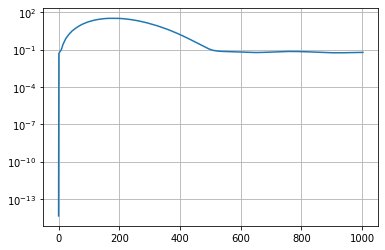

In [7]:
# ifstart and ifend can be determined from the figure below.
plt.yscale("log")
plt.plot(energy)
plt.grid()

In [8]:
ns, nr = pdown_f[0].shape
nk = nr//6 

l0 = np.eye(nr, nk)+np.eye(nr, nk)*1j ## initial for mdd
r0 = l0.T

In [9]:
beta = [None, None]

tau = [1e-1, 1e-1]

prox = [l2_prox, l2_prox]

In [19]:
ifstart, ifend = 10, 580

ret = []

pdown_f = pdown_f.astype(np.complex64)
pup_f   = pup_f.astype(np.complex64)

l0 = l0.astype(np.complex64)
r0 = r0.astype(np.complex64)

for idx_f in range(ifstart, ifend):
    
    d, u = pdown_f[idx_f], pup_f[idx_f]

    Op = mdd_xlr(d, ns, nr, nk)

    ret_ = ipalm(Op, u.ravel(), prox, tau, 0, iter_lim=15000, x0=[l0.ravel(), r0.ravel()], tol=1e-7, show=0)
    l0, r0 = ret_[0], ret_[1]
    ret.append(ret_)


In [20]:
ret = np.array(ret)

In [21]:
# reshape 1-d array l and r to nr \times nk and nk \times nr for each frequency
l, r = ret[:,0], ret[:,1]
l.shape, r.shape
nf = ifend - ifstart
l, r = l.reshape((nf, *Op.lrshape[0])), r.reshape((nf, *Op.lrshape[-1]))

In [22]:
x = np.matmul(l,r) ## l, r to x

In [23]:
xx=np.zeros((ifend, nr,nr))*1j
xx[ifstart:]=x

In [24]:
x_xt = np.fft.irfft(xx, n=nt, axis=0) ## from f-x to t-x

In [25]:

ret = []
for idx_f in range(ifstart, ifend):

    d, u = pdown_f[idx_f], pup_f[idx_f]

    Op = mdd_xqqt(d, ns, nr, nk) ## x factorized into q.dot(q.T)

    ret_ = ipalm(Op, u.ravel(), prox, tau, 0, iter_lim=15000, x0=[l0.ravel()], tol=1e-7, show=0)
    l0 = ret_[0]
    ret.append(ret_)

In [27]:
ret = np.array(ret)
ret.shape

(570, 1, 3775)

In [28]:
q = ret
q = q.reshape((nf, *Op.qshape[0]))

In [29]:
x2 = np.matmul(q, q.transpose(0,2,1))

In [30]:
xx2=np.zeros((ifend, nr, nr))*1j
xx2[ifstart:]=x2
x_xt2 = np.fft.irfft(xx2, n=nt, axis=0)

Text(0.5, 1.0, 'Common receiver with n/k=6')

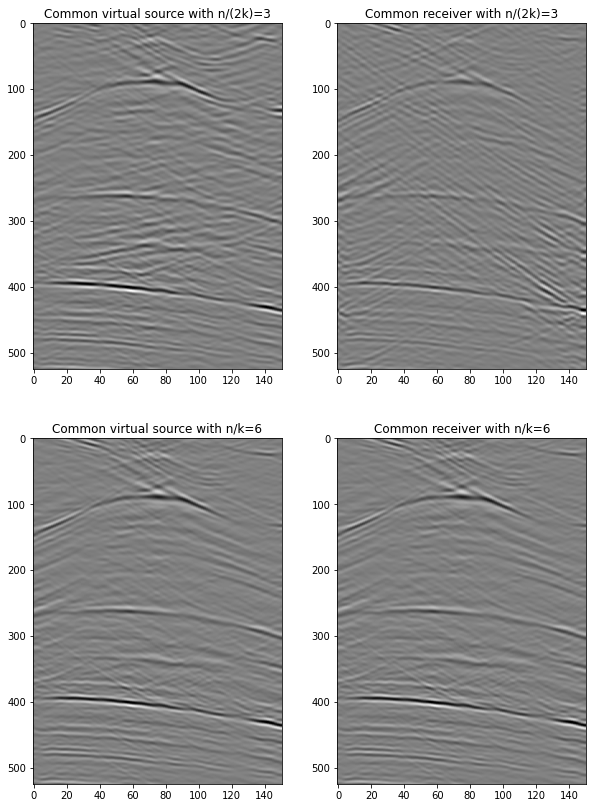

In [50]:
fig, axs = plt.subplots(2,2, figsize=(10,14))
pclip = 0.8

dat = x_xt[:525, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[0][0].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common virtual source with n/(2k)=%d'%(nr//nk//2)
axs[0][0].set_title(title)


dat = x_xt[:525, :, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[0][1].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common receiver with n/(2k)=%d'%(nr//nk//2)
axs[0][1].set_title(title)

dat = x_xt2[:525, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[1][0].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common virtual source with n/k=%d'%(nr//nk)
axs[1][0].set_title(title)

dat = x_xt2[:525, :, 75] ## the case of factorizing x into l.dot(r) 
cc = np.abs(dat).max()
axs[1][1].imshow(dat, aspect=0.4, vmin=-cc*pclip, vmax=cc*pclip, cmap="gray")
title = 'Common receiver with n/k=%d'%(nr//nk)
axs[1][1].set_title(title)